## Imports and Functions

In [1]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
from onix.models.schiff import inverse_fa_limit
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev, mdev
from astropy.timeseries import LombScargle

In [2]:
fft_end_time_s = 20e-6
fft_first_N = 99
fft_average_scan = 3

In [3]:
def phase_fit(phi, A, B, C, phi_0):
    return A * np.cos(phi - phi_0) +  B * phi + C

def get_phase_fitter(phases, heights, height_errs):
    fitter = Fitter(phase_fit)
    fitter.set_data(phases, heights, height_errs)
    fitter.set_bounds("A", 0, np.inf)

    # setting this bound makes weird fits for certain phi_0's because they want to fit to a value outside the bound
    # fitter.set_bounds("phi_0", 0, 2*np.pi)
    fitter.fit()
    return fitter


In [4]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [5]:
def get_cycle_snr(num_samples = 5):
    """
    Picks num_samples many ramsey fringes at random and computes their SNR. 
    Returns snr = {
        data_range: [SNR of lambda = 1 data, SNR of lambda = -1 data]
    }
    """
   # find how many points we use per ramsey fringe
    d, h = get_experiment_data(data_range[0])
    points_per_fringe = len(h["params"]["lf"]["phase_diffs"])

    # find the number of ramsey experiments in the data set
    num_fringes = ((max - data_range[0])//points_per_fringe) + 1
    
    # take some random ramsey fringes
    rng = np.random.default_rng()
    rints = rng.integers(low=0, high=num_fringes+1, size=num_samples)
    data = {}
    # compute the data numbers corresponding to these fringes
    for i in rints:
        random_fringe_data_range = (data_range[0] + points_per_fringe * i - 1, data_range[1] + points_per_fringe * i -1)
        data[f"Fringe {i}"] = random_fringe_data_range
        if any(x in ignore_data_numbers for x in np.arange(random_fringe_data_range[0], random_fringe_data_range[-1] + 1, 1)):
            get_cycle_snr(num_samples = num_samples)
        # if any of random_fringe_data_range is in ignore_data_numbers just call the function again

    snr = _get_cylce_snr(data)
    return snr

def _get_cylce_snr(data):
    """
    Mostly copy past from the Ramsey plot and fit code
    """
    snr = {
        "data range": "[lambda = 1 SNR, lambda = -1 SNR]"
    }
    index = []
    for ll, (label, data_range) in enumerate(data.items()):
        headers, results_temp = get_results(data_range)
        mask = np.ones(len(headers), dtype=bool)
        for kk, header in enumerate(headers):
            sequence = header["params"]["sequence"]["sequence"]
            if header["params"]["field_plate"]["amplitude"] < 0:
                mask[kk] = True
            for name, repeat in sequence:
                if name.startswith("lf"):
                    index.append(int(name.split("_")[-1]))
                    break
        xs = np.array([header["params"]["lf"]["phase_diffs"][index[kk]] for kk, header in enumerate(headers)])
        if results_temp.ndim == 1:
            ys = unumpy.nominal_values(results_temp)
            errs = unumpy.std_devs(results_temp)
        else:
            snr_plus_minus = []
            for kk in range(0, 2):
                ys = unumpy.nominal_values(results_temp[:, kk])
                errs = unumpy.std_devs(results_temp[:, kk])
                xs_avg, ys_avg, errs_avg = averaging_ys(xs[mask], ys[mask])
                fitter = get_phase_fitter(xs_avg, ys_avg, None)
                xs_fit = np.linspace(np.min(xs_avg), np.max(xs_avg), 100)
                ys_fit = fitter.fitted_value(xs_fit)
                snr_plus_minus.append(fitter.results['A']/fitter.errors['A'])
        
        snr[data_range] = snr_plus_minus
    return snr

In [6]:
def get_normalized_transmission(data_number):
    data, header = get_experiment_data(data_number)
    if "fid" in header["params"]["detect"] and header["params"]["detect"]["fid"]["use"]:
        sample_rate = header["params"]["digitizer"]["sample_rate"]
        fid_params = header["params"]["detect"]["fid"]
        start_time = (fid_params["pump_time"] + fid_params["wait_time"]).to("s").magnitude + 7e-6
        fft_end_time = start_time + fft_end_time_s
        times = np.arange(len(data["transmissions_avg"][0])) / sample_rate
        mask = (times > start_time) & (times < fft_end_time)
        time_resolution = times[1] - times[0]
        fs = np.fft.rfftfreq(len(data["transmissions_avg"][0][mask]), d=time_resolution)
        duration = times[mask][-1] - times[mask][0]
        N = duration / time_resolution
        freqs_to_probe = []
        center_detuning = (header["params"]["detect"]["fid"]["probe_detuning"] - header["params"]["detect"]["detunings"][0]).to("Hz").magnitude
        if header["params"]["field_plate"]["use"]:
            electric_field_shift = header["params"]["field_plate"]["stark_shift"].to("Hz").magnitude
            freqs_to_probe.append(center_detuning - electric_field_shift)
            freqs_to_probe.append(center_detuning + electric_field_shift)
        else:
            freqs_to_probe.append(center_detuning)
        freqs_to_probe = np.abs(freqs_to_probe)
        detunings_MHz = np.array(freqs_to_probe) * 1e-6
        indices_to_probe = []
        for freq in freqs_to_probe:
            closest_index = np.argmin(np.abs(fs - freq))
            indices_to_probe.append(closest_index)
        normalized_avg = [[] for kk in freqs_to_probe]
        for kk, d in enumerate(data["transmissions_avg"]):
            if kk >= fft_first_N:
                continue
            ys = np.fft.rfft(d[mask]) * 2 / N
            for ll, closest_index in enumerate(indices_to_probe):
                normalized_avg[ll].append(np.sum(np.abs(ys[closest_index - fft_average_scan: closest_index+fft_average_scan+1])))
        normalized_avg_avg = np.abs(np.average(normalized_avg, axis=1))
        # normalized_avg_std = np.std(np.abs(np.array(normalized_avg) - normalized_avg_avg), axis=1)
        # normalized_avg_std /= len(normalized_avg[0])
        normalized_avg = {"3": -unumpy.uarray(normalized_avg_avg, np.zeros(len(normalized_avg_avg))), "6": ufloat(0,0)}

    else:
        detunings_MHz = header["detunings"].to("MHz").magnitude
        transmissions_avg, transmissions_err = group_and_average_data(data["transmissions_avg"], header["params"]["detect"]["cycles"], return_err=True)
        monitors_avg, monitors_err = group_and_average_data(data["monitors_avg"], header["params"]["detect"]["cycles"], return_err=True)
        normalized_avg = {}
        for kk in transmissions_avg:
            if transmissions_avg[kk].ndim >= 1:
                normalized_avg[kk] = unumpy.uarray(
                    transmissions_avg[kk] / monitors_avg[kk],
                    np.sqrt(
                        (transmissions_err[kk] / monitors_avg[kk]) ** 2
                        + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                    )
                )
            else:
                normalized_avg[kk] = ufloat(
                    transmissions_avg[kk] / monitors_avg[kk],
                    np.sqrt(
                        (transmissions_err[kk] / monitors_avg[kk]) ** 2
                        + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                    )
                )
    return detunings_MHz, normalized_avg, header

In [7]:
def get_experiment_result(data_number):
    detunings, data, header = get_normalized_transmission(data_number)
    total_pop_1 = 1#data["1"] - data["2"]
    pop_other_state_1 = -data["3"]#data["1"] - data["3"]
    
    total_pop_2 = 1#data["4"] - data["5"]
    pop_other_state_2 = -data["6"]#data["4"] - data["6"]
    # print(total_pop_1, total_pop_2)
    return (header, pop_other_state_1 + pop_other_state_2, total_pop_1 + total_pop_2)

In [8]:
def get_results(data_identification):
    data_list = data_identification_to_list(data_identification)
    headers = []
    results = []
    for data_number in data_list:
        header, pop_other_state, total_pop = get_experiment_result(data_number)
        headers.append(header)
        results.append(pop_other_state / total_pop)
    return headers, np.array(results)

In [9]:
def averaging_ys(xs, ys):
    xs_unique = np.unique(xs)
    ys_to_avg = [[] for _ in range(len(xs_unique))]
    for x, y in zip(xs, ys):
        ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
    ys_avg = []
    ys_std = []
    for y_list in ys_to_avg:
        ys_avg.append(np.average(y_list))
        ys_std.append(np.std(y_list))
    ys_avg = np.array(ys_avg)
    ys_std = np.array(ys_std)
    
    return xs_unique, ys_avg, ys_std

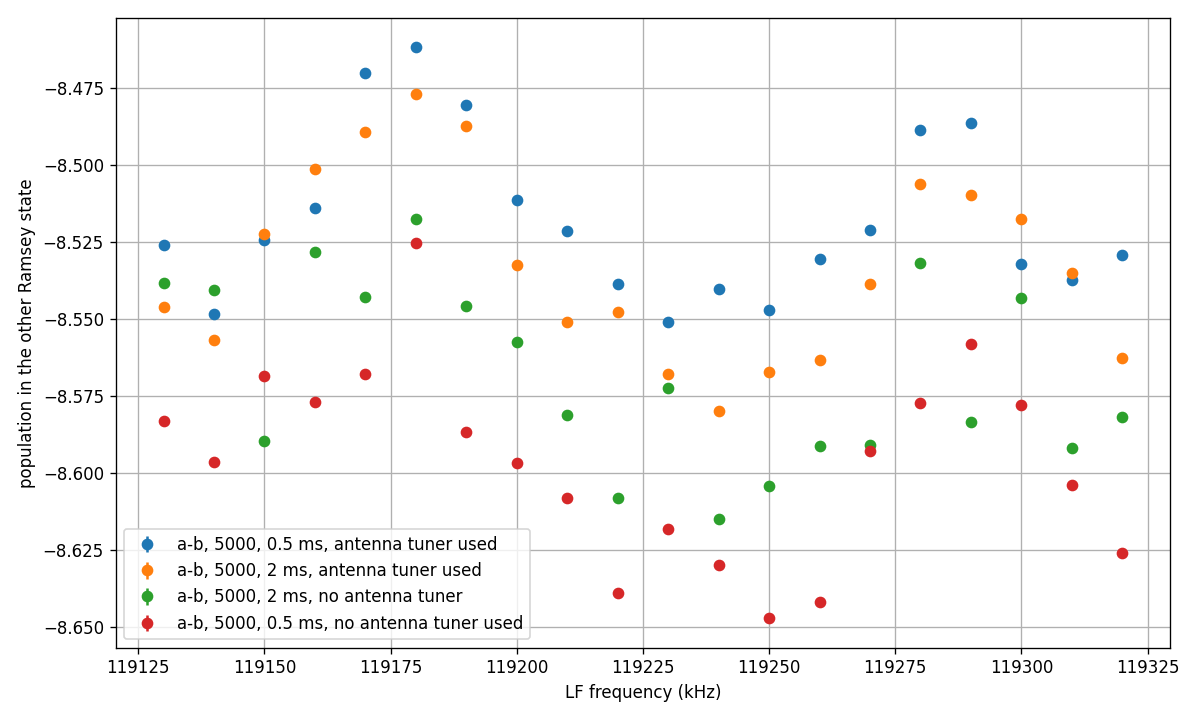

In [10]:
data = {
    # "a-abar, 90 us, 90 us": (978080, 978109),
    # "b-bbar, 25 us, 50 us": (985461, 985510),
    # "a-b, 5000, 100 us": (1031448, 1031647),
    # "b-bbar, 25 us, 50 us, 2.1 MHz": (1036477, 1036526),
    # "b-bbar, 25 us, 50 us, 2 MHz": (1036570, 1036605),
    "a-b, 5000, 0.5 ms, antenna tuner used": (1991507, 1991526),
    "a-b, 5000, 2 ms, antenna tuner used": (1991527, 1991546),
    "a-b, 5000, 2 ms, no antenna tuner": (1991547, 1991566),
    "a-b, 5000, 0.5 ms, no antenna tuner used": (1991567, 1991586),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results_temp = get_results(data_range)
    xs = [(header["params"]["lf"]["detunings"][0] + header["params"]["lf"]["center_frequencies"][0]).to("kHz").magnitude for header in headers]
    if results_temp.ndim == 1:
        ys = unumpy.nominal_values(results_temp)
        errs = unumpy.std_devs(results_temp)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(1):
            ys = unumpy.nominal_values(results_temp[:, kk])
            errs = unumpy.std_devs(results_temp[:, kk])
            ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')

ax.set_xlabel("LF frequency (kHz)")
ax.set_ylabel("population in the other Ramsey state")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [11]:
d,h = get_experiment_data(1625324)  # (1625324, 1625332)
h["temp"]

14.2929

In [12]:
1552306 + 17 * 50, 1552322 + 17 * 99

(1553156, 1554005)

## Plot Ramsey Fringe

In [174]:
data_range = (2232617, 2232625) # 2000 amplitude, 0.025 ms pi / 2
max = 2235469

2226077

[4. 5. 6. 7. 8. 0. 1. 2. 3.]
12.5 us pi / 2
A = 0.074(12) 
B = 0.002(4) 
C = -8.913(14) 
phi_0 = -1.57(12) 
12.5 us pi / 2
A = 0.072(12) 
B = 0.002(4) 
C = -8.846(14) 
phi_0 = -1.60(12) 


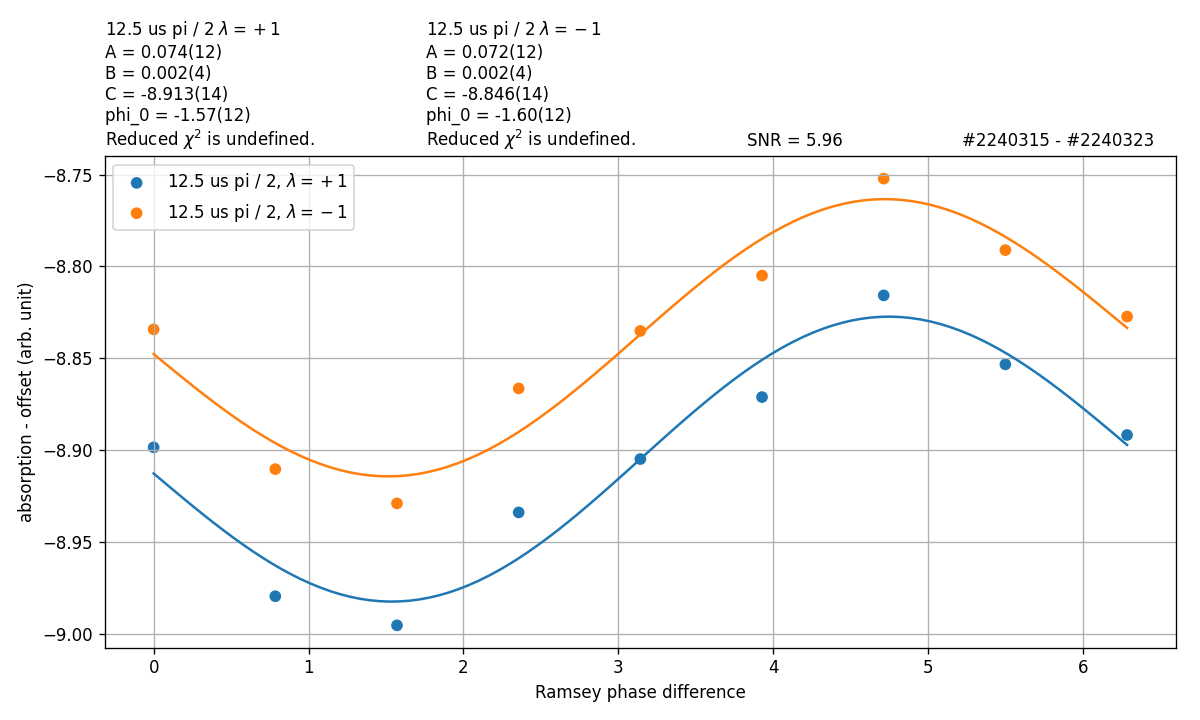

SNR with 9 phase points = 5.957105239393997


In [183]:
data_range = 2237773, 2237781 # 500 amplitude 0.1 ms pi / 2 time
max = 2242866
num_fringes = (max - data_range[1]) / 9
offset = round((num_fringes / 2) * 9 )
do_average = True
data = {
    #"FID test 10 s": (2172332, 2172340),
    #"FID test 1 s": (2172423, 2172431),
    "12.5 us pi / 2": (int(data_range[0] + offset), int(data_range[1] + offset)),
}

index = []
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results_temp = get_results(data_range)
    mask = np.ones(len(headers), dtype=bool)
    for kk, header in enumerate(headers):
        sequence = header["params"]["sequence"]["sequence"]
        if header["params"]["field_plate"]["amplitude"] < 0:
            mask[kk] = True
        for name, repeat in sequence:
            if name.startswith("lf") and not name.endswith("piov2"):
                index.append(int(name.split("_")[-1]))
                break
    xs = np.array([header["params"]["lf"]["phase_diffs"][index[kk]] for kk, header in enumerate(headers)])
    print(xs[:17] / np.pi * 4)
    if results_temp.ndim == 1:
        ys = unumpy.nominal_values(results_temp)
        errs = unumpy.std_devs(results_temp)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(0, 2):
            ys = unumpy.nominal_values(results_temp[:, kk])
            errs = unumpy.std_devs(results_temp[:, kk])
            if do_average:
                xs_avg, ys_avg, errs_avg = averaging_ys(xs[mask], ys[mask])
            else:
                xs_avg, ys_avg, errs_avg = xs, ys, errs
            if kk == 0:
                lambda_label = ", $\\lambda = +1$"
            else:
                lambda_label = ", $\\lambda = -1$"
            ax.scatter(xs_avg, ys_avg, label=label + lambda_label, marker='o', linestyle='')
            fitter = get_phase_fitter(xs_avg, ys_avg, None)
            xs_fit = np.linspace(np.min(xs_avg), np.max(xs_avg), 100)
            ys_fit = fitter.fitted_value(xs_fit)
            ax.plot(xs_fit, ys_fit)
            if kk == 0:
                label_str = label + " $\\lambda = +1$ \n" + fitter.all_results_str()
                ax.text(0,1.02, label_str, transform = ax.transAxes)
            else:
                label_str = label + " $\\lambda = -1$ \n" + fitter.all_results_str()
                ax.text(0.3,1.02, label_str, transform = ax.transAxes)
            print(label)
            print(fitter.result_str("A"))
            print(fitter.result_str("B"))
            print(fitter.result_str("C"))
            print(fitter.result_str("phi_0"))

ax.set_xlabel("Ramsey phase difference")
ax.set_ylabel("absorption - offset (arb. unit)")
ax.text(0.8,1.02,f"#{data['12.5 us pi / 2'][0]} - #{data['12.5 us pi / 2'][1]}" , transform = ax.transAxes)
ax.text(0.6,1.02, f"SNR = {round(fitter.results['A']/fitter.errors['A'],2)}", transform = ax.transAxes)
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()
print(f"SNR with 9 phase points = {fitter.results['A']/fitter.errors['A']}")

## LF Rabi Flopping

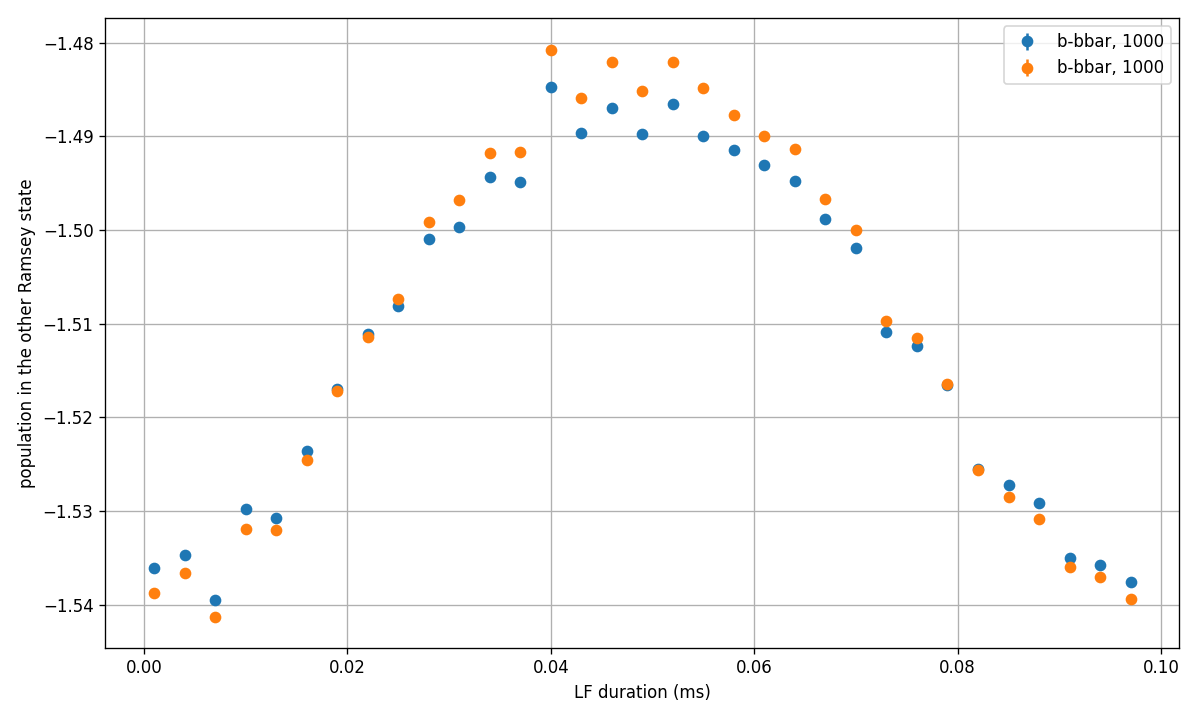

In [150]:
data = {
    #"b-bbar, 1500": (985296, 985328),
    # "b-bbar, 1400": (985329, 985361),
    # "b-bbar, 1200": (985362, 985394),
    #"b-bbar, 900": (985395, 985427),
    "b-bbar, 1000": (985428, 985460),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results_temp = get_results(data_range)
    xs = [(header["params"]["lf"]["durations"][0]).to("ms").magnitude for header in headers]
    if results_temp.ndim == 1:
        ys = unumpy.nominal_values(results_temp)
        errs = unumpy.std_devs(results_temp)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(2):
            ys = unumpy.nominal_values(results_temp[:, kk])
            errs = unumpy.std_devs(results_temp[:, kk])
            ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')

ax.set_xlabel(f"LF duration (ms)")
ax.set_ylabel("population in the other Ramsey state")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Long Term Phse Scan

In [13]:
import onix.models.hyperfine as hyperfine
magnetic_field = 223e-4
ground = hyperfine.states["7F0"]
ground._Hamiltonian = ground.H_total(magnetic_field)
e_g, s_g = ground.energies_and_eigenstates()

a_I_dot_n = (s_g[0].dag() * ground._I_x * s_g[0]).tr()
abar_I_dot_n = (s_g[1].dag() * ground._I_x * s_g[1]).tr()
b_I_dot_n = (s_g[2].dag() * ground._I_x * s_g[2]).tr()
bbar_I_dot_n = (s_g[3].dag() * ground._I_x * s_g[3]).tr()
I_a = (abar_I_dot_n - a_I_dot_n) / 2
I_b = (bbar_I_dot_n - b_I_dot_n) / 2

def combine_polarization_data(results):
    def check_equal_and_append(check_from, check_name, append_to):
        check_col = check_from[:, col_indices[check_name]]
        count = np.unique(check_col)
        if len(count) > 1:
            raise Exception(f"{check_name} is not the same.")
        append_to.append(check_col[0])

    results_array = pandas.DataFrame.from_dict(results).to_numpy()
    keys = list(results.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = {
        "f+": [],
        "f-": [],
        "start_time": [],
        "end_time": [],
        "temp": [],
        "phi0+": [],
        "phi0-": [],
    }
    for kk in range(len(results_array) // 2):
        sub_data = results_array[kk * 2: kk * 2 + 2]
        data_indices = []
        for name in results.keys():
            if name not in ["start_time", "end_time", "D", "freq_center", "temp", "phi0"]:
                if name not in data:
                    data[name] = []
                check_equal_and_append(sub_data, name, data[name])
        for ll, datapoint in enumerate(sub_data):
            if ll == 0:
                start_time = datapoint[col_indices["start_time"]]
            if ll == len(sub_data) - 1:
                end_time = datapoint[col_indices["end_time"]]
            if datapoint[col_indices["D"]]:
                f_p = datapoint[col_indices["freq_center"]]
                phi0_p = datapoint[col_indices["phi0"]]
            else:
                f_m = datapoint[col_indices["freq_center"]]
                phi0_m = datapoint[col_indices["phi0"]]


        data["f+"].append(f_p)
        data["f-"].append(f_m)
        data["phi0+"].append(phi0_p)
        data["phi0-"].append(phi0_m)
        data["start_time"].append(start_time)
        data["end_time"].append(end_time)
        data["temp"].append(np.nanmean(sub_data[:, col_indices["temp"]]))

    data["f+"] = np.array(data["f+"])
    data["f-"] = np.array(data["f-"])
    data["phi0+"] = np.array(data["phi0+"])
    data["phi0-"] = np.array(data["phi0-"])
    data["Z"] = (data["f+"] + data["f-"]) / 4
    data["W_T"] = []
    for kk in range(len(data["f+"])):
        if data["state"][kk] == "a":
            I = I_a
        else:
            I = I_b
        data["W_T"].append((data["f+"][kk] - data["f-"][kk]) / 4 / I)

    keys = list(data.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = pandas.DataFrame.from_dict(data).to_numpy()
    return data, col_indices

In [101]:
analysis_dnum = 613
ignore_data_numbers = []

In [32]:
# detect detunings
#data_range = (1737936, 1737944)
#max = 1744235

# temperature scan
# data_range = (1571153, 1571153+8)
# max = 1624846

# carrier frequency scan 1
data_range = (1555028, 1555034)
max = 1557043

# carrier frequency scan 2
# data_range = (1557099+90, 1557107+90)
# max = 1565792

# with rigol TTLed for field plate trigger
# data_range = (1746176+80*9, 1746184+80*9)
# max = 1756786

# E field ramp time scan, before lf
# data_range = (1758131, 1758139)
# max = 1780630  # possible bug in the data loading code. When there is not overlap it is still not happy.

# E field ramp time scan, after lf
# data_range = (1780631, 1780639)
# max = 1803130

# detect detuning scan with RIGOL
# data_range = (1803131, 1803139)
# max = 1816648 + 3000

# RF Amplitude and Duration Scan without temperature control
# data_range = (1847910, 1847918)
# max = 1947747

# #I have to interrupt the code, change param, and start again. This leaves some Ramsey fringes unfinished. We must ignore these data numbers.
# incomplete_data = [
#     # (first data number to ignore, last data number to ignore)
#     (1850196, 1850202),
#     (1860931, 1860932),
#     (1866936, 1866967),
#     (1869583, 1869584),
#     (1873311, 1873316),
#     (1875135, 1875140),
#     (1877579, 1877581),
#     (1878725, 1880525),
#     (1881660, 1881666),
#     (1882405, 1936625),
#     (1938867, 1938869),
#     (1939923, 1939925),
#     (1942365, 1942372),
#     (1943606, 1943606),
#     (1944813, 1944814),
#     (1945580, 1945587)
# ]

# ignore_data_numbers = np.concatenate([np.arange(kk[0], kk[1] + 1, 1) for kk in incomplete_data]).tolist()

## RF Scan while temp controlling
# data_range = (1949152, 1949160)
# max = 1951743

# running an experiment with the best rf params
# data_range = (1951744, 1951752)
# max = 1954587

## Ramp time constant, extra time delay scan (field plate during optical)
# data_range = (1882626, 1882634)
# max = 1909625

# ## Ramp time constant, extra time delay scan (field plate during detect)
# data_range = (1909626, 1909634)
# max = 1936625

## Further RF Optimization
# data_range = (1959115, 1959123)
# max = 1961994

# best rf params, 6.5 K
#data_range = (1962634, 1962642)
#max = 1963578

# best rf params 7 K
# data_range = (1963582, 1963590)
# max = 1979376

# # 50 OHM TUNED
# data_range = (1979809, 1979817)
# max = 1980735

# # test after RF flopping broke
# data_range = (1990063, 1990071)
# max = 1990296

In [382]:
# # overnight scan with optimized RF sweep and temperature control
# data_range = (2000869 + 9 * 150, 2000877 + 9 * 150)  # 256, 75 mHz
# max = 2003091
# data_range = (2003100, 2003108)  # 256 x 40 us, 51 mHz
# max = 2003495
# data_range = (2003500, 2003508)  # 256 x 160 us, 41 mHz
# max = 2003895
# data_range = (2003903, 2003911)  # 256 x 40 us, 2.1 MHz, 62 mHz
# max = 2004424
# data_range = (2004426, 2004740)  # 256 x 40 us, 2.1 MHz, same param as above, 56 mHz
# max = 2004686
# data_range = (2004746, 2004754)  # 256 x 40 us, 200, 2.1 MHz, 45 mHz
# max = 2005042
# data_range = (2005049, 2005057)  # 256 x 40 us, 200, 2.1 MHz, 0.4 s wait, 50 mHz
# max = 2005282
# data_range = (2005285, 2005293)  # 256 x 40 us, 200, 2.1 MHz, no wait, 26 mHz
# max = 2005896
# data_range = (2005905, 2005913)  # 256 x 40 us, 200, 2.2 MHz, no wait, 25 mHz
# max = 2006435
# data_range = (2006442, 2006450)  # 256 x 40 us, 200, 2.3 MHz, no wait, 29 mHz
# max = 2006990
# data_range = (2006996, 2007004)  # 256 x 160 us, 200, 2.2 MHz, no wait, 29 mHz
# max = 2007211
# data_range = (2007217, 2007225)  # 256 x 10 us, 200, 2.2 MHz, no wait, 39 mHz
# max = 2007576
# data_range = (2007585, 2007593)  # 256 x 40 us, 200, 2.2 MHz, no wait, overnight, 6.7 K
# max = 2138480 #all of the overnight data


##################################################### wait time scan for FID 100 cycles
# data_range = (2180870, 2180878) #0.01 s
# max = 2189446
# data_range = (2192662, 2192670) #0.05 s
# max = 2200374
# data_range = (2175006, 2175014) #0.1 s
# max = 2180862
# data_range = (2190591, 2190599) #0.5 s
# max = 2192660
# data_range = (2172423, 2172431) #1 s
# max = 2175014
# data_range = (2189453, 2189461) #5 s
# max = 2190586
# data_range = (2172224, 2172232) #10 s
# max = 2172412

# data_range = (2200381, 2200389) # overnight fid, 1s t_cooldown
# max = 2210381

# data_range = (2243743, 2243751)   # 4 hours fid, 0.1s t_cooldown
# max = 2243743 + 90*10

# data_range = (2348582, 2348590) # Aug 1 overnight, 1s no CTC setpoint (~ 5 K).
# max = 2379883
######################################################

# pi / 2 time and amplitude scan
# data_range = (2224736, 2224744) 
# max = 2242866

# incomplete_data = [
#     (2227426 + 1 , 2227451 - 1),
#     (2232607 + 1, 2232617 -1),
#     (2235469 + 1, 2235486 - 1),
#     (2237762 + 1,2237773 - 1),
#     (2241399 + 1, 2241418 - 1) 
# ]

# ignore_data_numbers = np.concatenate([np.arange(kk[0], kk[1] + 1, 1) for kk in incomplete_data]).tolist()

# data_range = (2200381, 2200389) # overnight fid, 1s t_cooldown
# max = 2220648

# pi / 2 time (2)
# data_range = (2380414, 2380422)
# max = 2382510

# pi / 2 time (3)
# data_range = (2382521, 2382529)
# max = 2388631

# # reprogramming the board every time
# data_range = (2388651, 2388659)
# max = 2397303

# got rid of new impedance matching so that rf params are correct again. changed cb to start of sequence, not the end
# data_range = (2397334, 2397342)
# max = 2398260

# changed cb pumps back to the end
# data_range = (2398264, 2398272)
# max = 2400549

# # proper pi / 2 time scan
# data_range = (2400553, 2400561)
# max = 2423016 

# final 50 us carrier scan
data_range = (2424983, 2424989)
max = 2426438

points_per_scan = data_range[1] - data_range[0]
first = data_range[0]
last = max
first_unprocessed = first
all_old_data = False
all_new_data = True

path_to_save = get_analysis_file_path(analysis_dnum, f"{first}_{last}_processed.npz")
dir = os.path.dirname(path_to_save)
for file in os.listdir(dir):
    start_str, stop_str, _ = file.split("_")
    start = int(start_str)
    stop = int(stop_str)
    if start == data_range[0]:
        all_new_data = False
        if stop == max:
            all_old_data = True
        first_unprocessed = stop + 1
        old_data_path = os.path.join(dir, file)
        loaded_data = np.load(old_data_path, allow_pickle = True)
        if all_old_data:
            print("Existing data loaded. All old data.")
        else:
            print("Existing data loaded. Analyzing new data.")
        break
    
current = first_unprocessed + points_per_scan
offset = 0
all_results = {
    "lf_center_freq": [],
    "freq_center": [],
    "state": [],
    "E": [],
    "D": [],
    "field_plate_amplitude": [],
    "electric_field_shift_MHz": [],
    "pulse_time_ms": [],
    "wait_time_ms": [],
    "ramp_time_ms": [],
    "start_time": [],
    "end_time": [],
    "detect_detuning_MHz": [],
    "temp": [],
    "rf_amplitude": [],
    "rf_duration_ms": [],
    "phi0": [],
}

heights = []
diff_heights = []

t1 = time.time()

if all_old_data is False:
    while current + offset <= max:
        data_range_now = (first_unprocessed + offset, first_unprocessed + points_per_scan + offset)
        if data_range_now[0] in ignore_data_numbers:
            offset += 1
            continue
        data_list = data_identification_to_list(data_range_now)
        headers, results = get_results(data_range_now)
    
        for header in headers:
            if "temp" not in header or header["temp"] is None:
                header["temp"] = np.nan
    
        index = []
        for header in headers:
            sequence = header["params"]["sequence"]["sequence"]
            for name, repeat in sequence:
                if name.startswith("lf") and not name.endswith("piov2"):
                    index.append(int(name.split("_")[-1]))
                    break
                    
        center_freq = headers[0]["params"]["lf"]["center_frequencies"][index[0]].to("Hz").magnitude
        pulse_time_ms = headers[0]["params"]["lf"]["durations"][0].to("ms").magnitude
        wait_time_ms = headers[0]["params"]["lf"]["wait_times"][0].to("ms").magnitude
        total_time_ms = pulse_time_ms + wait_time_ms
        detuning = headers[0]["params"]["lf"]["detunings"][0].to("Hz").magnitude
        ramp_time = headers[0]["params"]["field_plate"]["ramp_time"].to("ms").magnitude
        probe_freq = center_freq + detuning
        fp_amplitude = headers[0]["params"]["field_plate"]["amplitude"]
        stark_shift = headers[0]["params"]["field_plate"]["stark_shift"].to("MHz").magnitude
        detect_detuning = headers[0]["params"]["detect"]["detunings"].to("MHz").magnitude
        E_field = fp_amplitude > 0
        phases = [header["params"]["lf"]["phase_diffs"][index[kk]] for kk, header in enumerate(headers)]
        temp = np.nanmean([header["temp"] for header in headers])
        rf_amplitude = headers[0]["params"]["rf"]["amplitude"]
        rf_duration_ms = headers[0]["params"]["rf"]["T_ch"].to("ms").magnitude
    
        for kk in range(2):  # positive and negative Stark components.
            ys = unumpy.nominal_values(results[:, kk])
            errs = unumpy.std_devs(results[:, kk])
            fitter = get_phase_fitter(phases, ys, None)
            phi0 = ufloat(fitter.results["phi_0"], fitter.errors["phi_0"])
            phi0 = (np.pi + phi0) % (2 * np.pi) - np.pi
            freq_center = phi0 / (2 * np.pi) / (total_time_ms * 1e-3) + probe_freq
            
            neg_DdotE = kk == 0
            E = E_field
            D = (not neg_DdotE) == E
            epoch_times = (
                headers[0]["data_info"]["save_epoch_time"],
                headers[-1]["data_info"]["save_epoch_time"],
            )
            if probe_freq > 200e3:
                state = "a"
            else:
                state = "b"
            all_results["lf_center_freq"].append(center_freq)
            all_results["freq_center"].append(freq_center)
            all_results["state"].append(state)
            all_results["E"].append(E)
            all_results["D"].append(D)
            all_results["start_time"].append(epoch_times[0])
            all_results["end_time"].append(epoch_times[1])
            all_results["pulse_time_ms"].append(pulse_time_ms)
            all_results["wait_time_ms"].append(wait_time_ms)
            all_results["field_plate_amplitude"].append(fp_amplitude)
            all_results["electric_field_shift_MHz"].append(stark_shift)
            all_results["detect_detuning_MHz"].append(detect_detuning)
            all_results["ramp_time_ms"].append(ramp_time)
            all_results["temp"].append(temp)
            all_results["rf_amplitude"].append(rf_amplitude)
            all_results["rf_duration_ms"].append(rf_duration_ms)
            all_results["phi0"].append(phi0)
    
            heights.append(ys)
        if E_field:
            diff_heights.append(heights[-1] - heights[-2])
        else:
            diff_heights.append(heights[-2] - heights[-1])
        
        offset += len(list(data_list))
        
    new_results, col_indices = combine_polarization_data(all_results)

    if all_new_data:
        results = new_results
    else:
        results = np.concatenate((loaded_data["results"], new_results), axis = 0)

    try:
        np.savez(
            path_to_save,
            results=results,
            col_indices=col_indices,
        )
        if all_new_data is False:
            try:
                os.remove(old_data_path)
            except:
                print("New processed data saved but old file not deleted.")
    except:
        print("Cannot save processed data. Known issue if on windows computer.")
    print(np.average(np.std(heights, axis=0)))
    print(np.average(np.std(diff_heights, axis=0)))
    print("Done")
else:
    results = loaded_data["results"]
    col_indices = loaded_data["col_indices"].tolist()
    print("Done.")

Existing data loaded. All old data.
Done.


In [381]:
# durations = np.unique(results[:, col_indices["pulse_time_ms"]])
# duration_masks = [results[:, col_indices["pulse_time_ms"]] == kk for kk in durations]
# results = results[duration_masks[0]]

In [360]:
len(results)

416

In [361]:
results[5]

array([140042.52291535097+/-96.68998636076255,
       140046.2459335467+/-100.50727685947611, 1722544765.900596,
       1722544768.309939, 6.8183,
       -1.8589726611333048+/-0.27338449574400203,
       -1.8484460751817189+/-0.284177630352641, 140700.0, 'b', True, 4500,
       2.2, 0.1, 0.35, 3, array([0.]), 3875, 21,
       70022.19221222441+/-34.86641127588971,
       -1.2362107012020747+/-46.3089122487372], dtype=object)

In [378]:
results = np.delete(results, 5)
results[5]

140223.8918054635+/-83.5173888856439

In [383]:
a_mask = results[:, col_indices["state"]] == "a"
b_mask = results[:, col_indices["state"]] == "b"

E_fields = np.unique(results[:, col_indices["field_plate_amplitude"]])
E_masks = [results[:, col_indices["field_plate_amplitude"]] == kk for kk in E_fields]

rf_amplitudes = np.unique(results[:, col_indices["rf_amplitude"]])
rf_amplitude_masks = [results[:, col_indices["rf_amplitude"]] == kk for kk in rf_amplitudes]

rf_durations = np.unique(results[:, col_indices["rf_duration_ms"]])
rf_duration_masks = [results[:, col_indices["rf_duration_ms"]] == kk for kk in rf_durations]

durations = np.unique(results[:, col_indices["pulse_time_ms"]])
duration_masks = [results[:, col_indices["pulse_time_ms"]] == kk for kk in durations]

E_pos_mask = results[:, col_indices["E"]] == True
E_neg_mask = results[:, col_indices["E"]] == False

start_times_a = results[a_mask, col_indices["start_time"]]
start_times_b = results[b_mask, col_indices["start_time"]]
f_p_a = results[a_mask, col_indices["f+"]]
f_m_a = results[a_mask, col_indices["f-"]]
f_p_b = results[b_mask, col_indices["f+"]]
f_m_b = results[b_mask, col_indices["f-"]]

Z_a = results[a_mask, col_indices["Z"]]
Z_b = results[b_mask, col_indices["Z"]]
W_T_a = results[a_mask, col_indices["W_T"]]
W_T_b = results[b_mask, col_indices["W_T"]]

# temp1 = np.logical_and(results[:, col_indices["temp"]] >= 6.54 , results[:, col_indices["temp"]] <= 6.6)
# temp2 = np.logical_and(results[:, col_indices["temp"]] > 6.95 , results[:, col_indices["temp"]] <= 7.1)
# temp3 = np.logical_and(results[:, col_indices["temp"]] > 7.5 , results[:, col_indices["temp"]] <= 7.6)
# temp4 = np.logical_and(results[:, col_indices["temp"]] > 8.2 , results[:, col_indices["temp"]] <= 8.3)
# temp5 = np.logical_and(results[:, col_indices["temp"]] > 9 , results[:, col_indices["temp"]] <= 9.1)
# temp6 = np.logical_and(results[:, col_indices["temp"]] > 9.77 , results[:, col_indices["temp"]] <= 9.85)
# temp7 = np.logical_and(results[:, col_indices["temp"]] > 10.45 , results[:, col_indices["temp"]] <= 10.55)
# temp8 = np.logical_and(results[:, col_indices["temp"]] > 11.04 , results[:, col_indices["temp"]] <= 11.1)
# temp9 = np.logical_and(results[:, col_indices["temp"]] > 11.96 , results[:, col_indices["temp"]] <= 12)
# temp10 = np.logical_and(results[:, col_indices["temp"]] > 12.42 , results[:, col_indices["temp"]] <= 12.47)
# temp11 = np.logical_and(results[:, col_indices["temp"]] > 12.89 , results[:, col_indices["temp"]] <= 12.93)
# temp12 = np.logical_and(results[:, col_indices["temp"]] > 13.35 , results[:, col_indices["temp"]] <= 13.425)
# temp13 = np.logical_and(results[:, col_indices["temp"]] > 14.25 , results[:, col_indices["temp"]] <= 14.3)
# temp_masks = [temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8, temp9, temp10, temp11, temp12, temp13]

In [384]:
for jj in duration_masks:
   print(f"pi / 2 time = {results[jj, col_indices['pulse_time_ms']][0]*1e3} us \t # of Ramsey datasets = {len(results[jj, col_indices['pulse_time_ms']])}")

pi / 2 time = 50.0 us 	 # of Ramsey datasets = 208


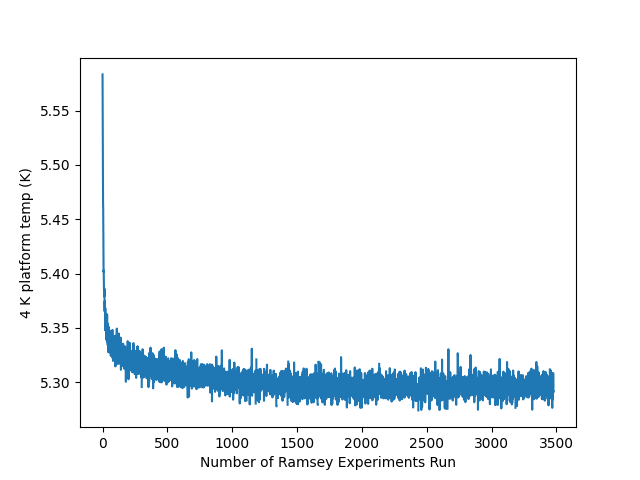

In [110]:
fig, ax = plt.subplots()

#data_numbers = first + np.arange(0, len(results[:, col_indices["W_T"]])) * 9
#temperatures = np.nan_to_num(results[:, col_indices["temp"]], nan = 0)
#ax.plot(data_numbers, temperatures)

ax.plot(results[:,col_indices["temp"]])
ax.set_xlabel("Number of Ramsey Experiments Run")
ax.set_ylabel("4 K platform temp (K)");

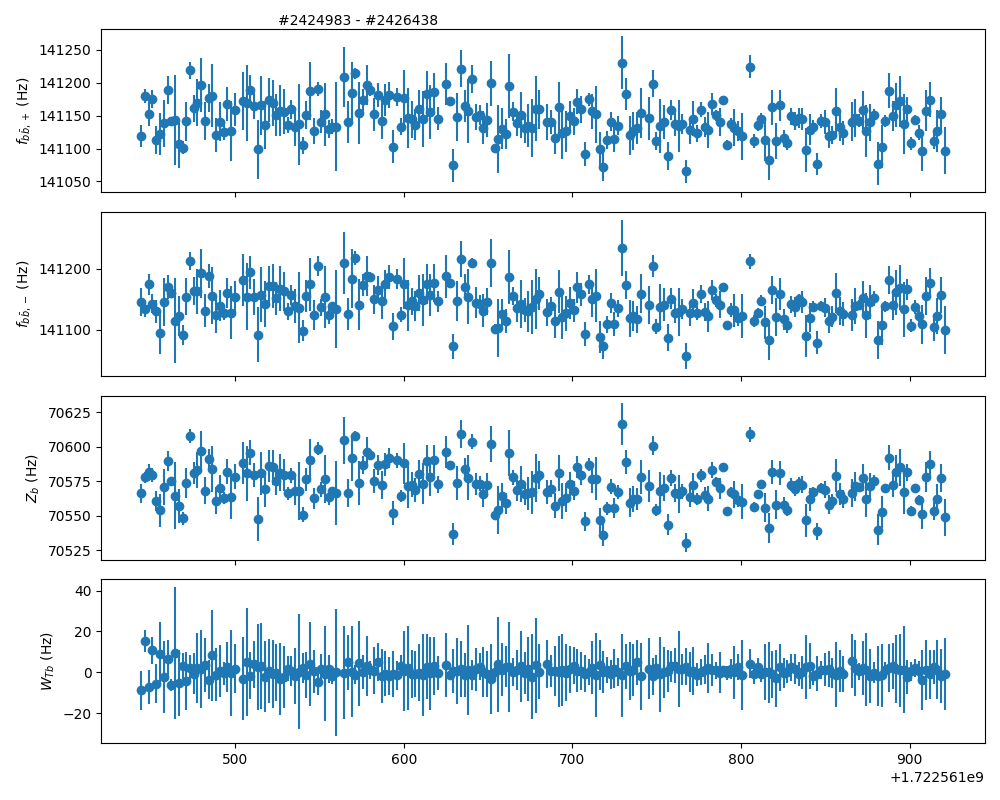

f_b,+ = 141145(2) Hz
f_b,- = 141143(2) Hz
Δf(b; D=±1 ,E=+1) = 1.0(3) Hz
Δf(b; D=±1 ,E=-1) = 0.4(3) Hz
W_T_b = 0.73(19) Hz


In [385]:
errorbar_args = {"fmt": "o", "ls": "none"}

masks = {}
if not np.all(a_mask == False):
    masks["a"] = a_mask
if not np.all(b_mask == False):
    masks["b"] = b_mask

cols = len(masks) * 4
fig, axs = plt.subplots(cols, 1, sharex=True, figsize=(10, cols*2))
for ll, mask_name in enumerate(masks):
    mask = masks[mask_name]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    
    axs[ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, +}$ (Hz)")
    axs[len(masks) + ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, -}$ (Hz)")
    axs[len(masks) * 2 + ll].set_ylabel("$Z_" + mask_name + "$ (Hz)")
    axs[len(masks) * 3 + ll].set_ylabel("$W_{T" + mask_name + "}$ (Hz)")
    for kk, d in enumerate(
        [
            results[mask, col_indices["f+"]],
            results[mask, col_indices["f-"]],
            results[mask, col_indices["Z"]],
            results[mask, col_indices["W_T"]]
        ]
    ):
        axs[kk * len(masks) + ll].errorbar(
            results[mask, col_indices["start_time"]], unumpy.nominal_values(d), unumpy.std_devs(d),
            **errorbar_args
        )
axs[0].text(0.2, 1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
plt.tight_layout()
plt.show()
if "a" in masks:
    mask = masks["a"]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    print("f_a,+ =", present_float(np.average(unumpy.nominal_values(f_p_a)), np.average(np.std(unumpy.nominal_values(f_p_a))) / np.sqrt(len(f_p_a))), "Hz")
    print("f_a,- =", present_float(np.average(unumpy.nominal_values(f_m_a)), np.average(np.std(unumpy.nominal_values(f_m_a))) / np.sqrt(len(f_m_a))), "Hz")
    print("Δf(a; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_a[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_a[E_pos]))) / np.sqrt(len(W_T_a[E_pos]))), "Hz")
    print("Δf(a; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_a[E_neg])), np.average(np.std(unumpy.nominal_values(W_T_a[E_neg]))) / np.sqrt(len(W_T_a[E_neg]))), "Hz")
if "b" in masks:
    mask = masks["b"]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
    print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
    print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
    print("Δf(b; D=±1 ,E=-1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_neg])), np.average(np.std(unumpy.nominal_values(W_T_b[E_neg]))) / np.sqrt(len(W_T_b[E_neg]))), "Hz")
    print("W_T_b =", present_float(np.average(unumpy.nominal_values(W_T_b)), np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))), "Hz")

In [387]:
duration = np.max(results[:, col_indices["start_time"]]) - np.min(results[:, col_indices["start_time"]])
E_pos = E_pos_mask[mask]
E_neg = E_neg_mask[mask]

W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))
duration = np.max(results[mask, col_indices["start_time"]]) - np.min(results[mask, col_indices["start_time"]])

print(f'#{first} - #{last}')
print(f"Time: {duration} s")
print(f"Number of Ramsey Expts. : {len(results)}")
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")
print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
print("Δf(b; D=±1 ,E=-1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_neg])), np.average(np.std(unumpy.nominal_values(W_T_b[E_neg]))) / np.sqrt(len(W_T_b[E_neg]))), "Hz")

T_ramsey = np.unique(results[:, col_indices["wait_time_ms"]] + results[:, col_indices["pulse_time_ms"]])[0] * 1e-3
N_cycles = len(results[:, 0])
df_plus = np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))
df_minus = np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))
inferred_SNR_plus = 1/(2*T_ramsey) / (df_plus * np.sqrt(N_cycles))
inferred_SNR_minus = 1/(2*T_ramsey) / (df_minus * np.sqrt(N_cycles))
print(f"Inferred SNR +  = {inferred_SNR_plus}")
print(f"Inferred SNR -  = {inferred_SNR_minus}")
get_cycle_snr(5)

#2424983 - #2426438
Time: 476.5097270011902 s
Number of Ramsey Expts. : 208
0.069 Hz sqrt(hr)
f_b,+ = 141145(2) Hz
f_b,- = 141143(2) Hz
W_T = 0.73(19) Hz
Δf(b; D=±1 ,E=+1) = 1.0(3) Hz
Δf(b; D=±1 ,E=-1) = 0.4(3) Hz
Inferred SNR +  = 41.79798375235452
Inferred SNR -  = 41.594223615574876


{'data range': '[lambda = 1 SNR, lambda = -1 SNR]',
 (2426130, 2426136): [17.86133717042259, 17.46487637104288],
 (2425262, 2425268): [14.068879288844142, 16.80228967901803],
 (2425423, 2425429): [24.625932679118314, 28.528012780371245],
 (2425010, 2425016): [9.623225381446575, 14.923811587185579],
 (2425346, 2425352): [9.853710679891414, 9.490592953202514]}

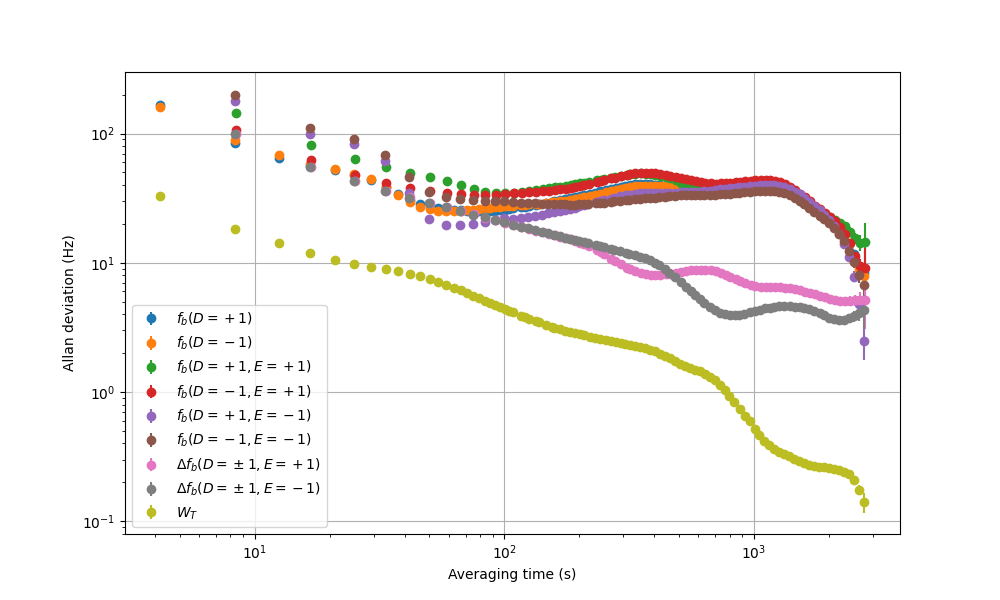

In [88]:
times = results[:, col_indices["start_time"]].astype(float)
taus = np.logspace(0, np.log10(len(times)) * 3, 500)
total_time = times[-1] - times[0]

allan_variables = [
    ("$f_b (D=+1)$", unumpy.nominal_values(results[:, col_indices["f+"]])),
    ("$f_b (D=-1)$", unumpy.nominal_values(results[:, col_indices["f-"]])),
    ("$f_b (D=+1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f+"]])),
    ("$f_b (D=-1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f-"]])),
    ("$f_b (D=+1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f+"]])),
    ("$f_b (D=-1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f-"]])),
    (
        "$\\Delta f_b (D=\\pm1, E=+1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == True, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == True, col_indices["f-"]]
        )
    ),
    (
        "$\\Delta f_b (D=\\pm1, E=-1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == False, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == False, col_indices["f-"]]
        )
    ),
    ("$W_T$", unumpy.nominal_values(results[:, col_indices["W_T"]])),
]
step_sizes = [total_time / len(kk[1]) for kk in allan_variables]

fig, ax = plt.subplots(figsize=(10, 6))
for kk, (label, variable) in enumerate(allan_variables):
    real_taus, allan, allan_err, _ = mdev(variable, data_type="freq", taus=taus)
    real_taus *= step_sizes[kk]
    ax.errorbar(real_taus, allan, allan_err, label=label, ls="none", fmt="o")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()
ax.set_xlabel("Averaging time (s)")
ax.set_ylabel("Allan deviation (Hz)")
plt.show()

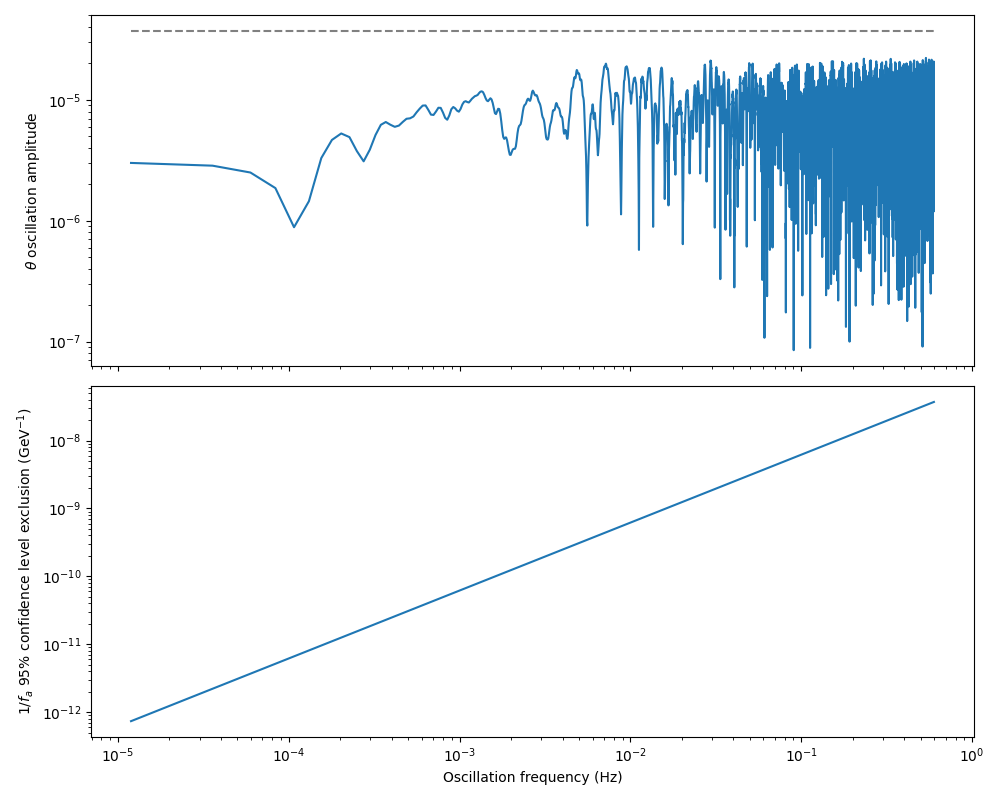

In [89]:
W_T_to_theta = 2.5e-5
# https://electricatoms.wordpress.com/2024/07/11/t-violation-measurement-from-lf-spectroscopy/
thetas = unumpy.nominal_values(results[:, col_indices["W_T"]]) * W_T_to_theta

theta_uncs = np.std(thetas) * np.ones(len(thetas))  # assuming error bar is std of the data for every point
ls = LombScargle(times, thetas, theta_uncs, normalization="psd")
fs, f_thetas_psd = ls.autopower()
f_thetas_amplitude_normalized = np.sqrt(f_thetas_psd / (len(f_thetas_psd) / 4))
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
f_thetas_amplitude = f_thetas_amplitude_normalized * np.std(thetas)
# https://docs.astropy.org/en/stable/timeseries/lombscargle.html#psd-normalization-unnormalized

confidence = 0.95
f_thetas_limit_psd = ls.false_alarm_level(1 - confidence)
f_thetas_limit_amplitude = np.sqrt(f_thetas_limit_psd / (len(f_thetas_psd) / 4)) * np.std(thetas)
# same normalization as above

inverse_fa_limits = inverse_fa_limit(fs, f_thetas_limit_amplitude * np.ones(len(fs)))

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(fs, f_thetas_amplitude)
ax[0].hlines([f_thetas_limit_amplitude], np.min(fs), np.max(fs), color="gray", ls="--", label=f"{confidence*100:.0f}%")
ax[0].set_ylabel("$\\theta$ oscillation amplitude")
ax[0].set_xscale("log")
ax[0].set_yscale("log")

ax[1].plot(fs, inverse_fa_limits)
ax[1].set_xlabel("Oscillation frequency (Hz)")
ax[1].set_ylabel(f"$1 / f_a$ {confidence*100:.0f}% confidence level" + " exclusion (GeV$^{-1}$)")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
plt.tight_layout()
plt.show()

In [24]:
## RF Amplitude and Duration Scan
# amplitude_axis = []
# duration_axis = []
# vals = []

# for duration_mask in rf_duration_masks:
#     vals_duration_fixed = []
#     for amplitude_mask in rf_amplitude_masks:
#         try:
#             W_T_values = unumpy.nominal_values(results[duration_mask&amplitude_mask, col_indices["W_T"]])
#             W_T_err = np.std(W_T_values) / np.sqrt(len(W_T_values))
#             duration = results[duration_mask&amplitude_mask, col_indices["rf_duration_ms"]][0]
#             amplitude = results[duration_mask&amplitude_mask, col_indices["rf_amplitude"]][0]
#             ramsey_fringe_time = results[duration_mask&amplitude_mask, col_indices["end_time"]][-1] - results[duration_mask&amplitude_mask, col_indices["start_time"]][0]
#             vals_duration_fixed.append(W_T_err / np.sqrt((3600 / ramsey_fringe_time)))
#             if amplitude not in amplitude_axis:
#                 amplitude_axis.append(amplitude)
#         except:
#             print("skipping")
#             continue
#     vals.append(vals_duration_fixed)
#     duration_axis.append(duration)

# fig, ax = plt.subplots()
# im = ax.imshow(vals, aspect='auto')
    
# # Show all ticks and label them with the respective list entries
# ax.set_yticks(np.arange(len(duration_axis)), labels=[round(i, 2) for i in duration_axis])
# ax.set_xticks(np.arange(len(amplitude_axis)), labels=[round(i, 2) for i in amplitude_axis])

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# # Loop over data dimensions and create text annotations.
# for i in range(len(duration_axis)):
#     for j in range(len(amplitude_axis)):
#         text = ax.text(j, i, round(vals[i][j], 3),
#                        ha="center", va="center", color="w")
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks(ax.get_xticks())
# ax2.set_xticklabels([round(i * 2.5 / 32768, 2) for i in amplitude_axis])
# ax2.set_xlabel("RF Amplitude (V)")

# ax.set_ylabel("RF Duration (ms)")
# ax.set_xlabel("RF Amplitude (AWG Units)")
# ax.set_title("$\\delta W_{Tb} / \\sqrt{T}$ (Hz $\\sqrt{hr}$) with 4 K Platform at 7 K")
# fig.tight_layout()
# plt.show()

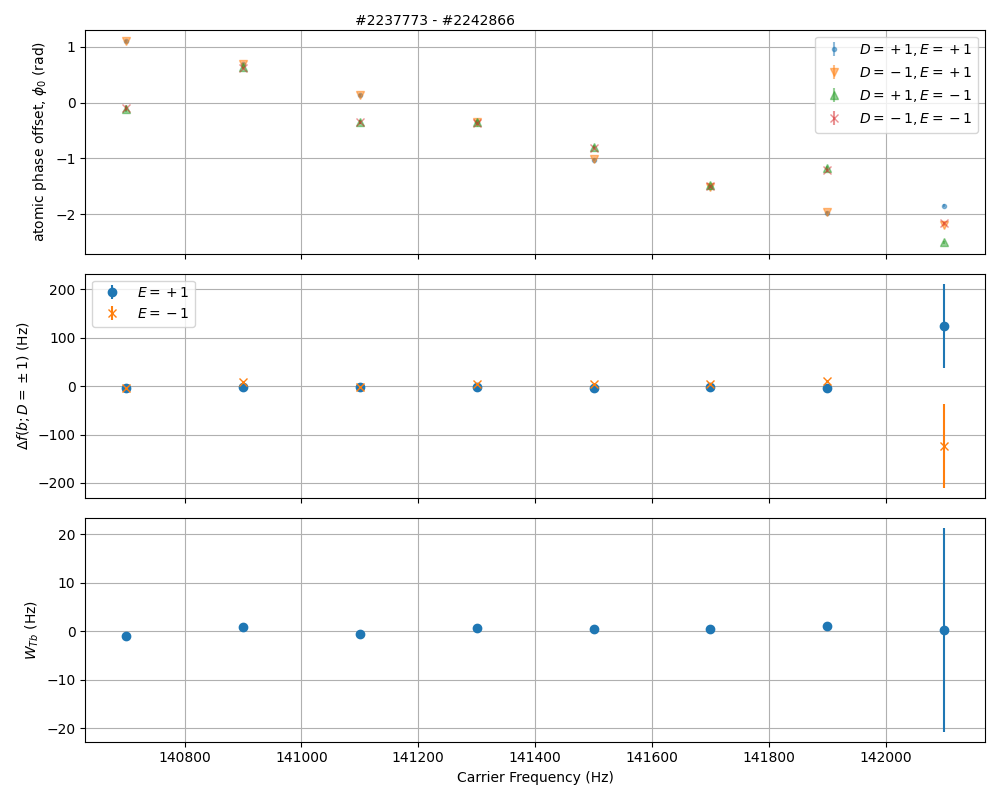

In [68]:
plot_label = "lf_center_freq"
x_label = "Carrier Frequency (Hz)"
take_absolute = False
col = results[:, col_indices[plot_label]]
if take_absolute:
    col = abs(col)
x = np.unique(col)
x_masks = []
for x_value in x:
    x_masks.append(col == x_value)
# x = x + 3
# plot_label = "Temperature Scan"
# x_label = "4 K Platform Temperature (K)"

# x = []
# x_std = []
# for mask in temp_masks:
#     val = np.mean(results[mask, col_indices["temp"]])
#     std = np.std(results[mask, col_indices["temp"]])
#     x.append(val)
#     x_std.append(std)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ds = []
ers = []
for EE in [E_pos_mask, E_neg_mask]:
    for ff in ["phi0+", "phi0-"]:
        d = []
        er = []
        for kk in range(len(x)):
            frequencies = results[b_mask&EE&x_masks[kk], col_indices[ff]]
            nom = unumpy.nominal_values(frequencies)
            unc = unumpy.std_devs(frequencies)
            d.append(np.average(nom))
            er.append(np.average(unc)/np.sqrt(len(unc)))
            
        ds.append(d)
        ers.append(er)

axs[0].errorbar(x, ds[0], yerr = ers[0], label="$D = +1, E = +1$", ls="", alpha=0.5, marker = ".")
axs[0].errorbar(x, ds[1], yerr = ers[1], label="$D = -1, E = +1$", ls="", alpha=0.5, marker = "v")
axs[0].errorbar(x, ds[2], yerr = ers[2], label="$D = +1, E = -1$", ls="", alpha=0.5, marker = "^")
axs[0].errorbar(x, ds[3], yerr = ers[3], label="$D = -1, E = -1$", ls="", alpha=0.5, marker = "x")
axs[0].grid()
axs[0].legend()

W_T_temp = []
W_T_temp_err = []

delta_f_temp_E_pos = []
delta_f_temp_E_pos_err = []

delta_f_temp_E_neg = []
delta_f_temp_E_neg_err = []

for mask in x_masks:
    W_T = unumpy.nominal_values(results[mask, col_indices["W_T"]])
    delta_f_E_pos = unumpy.nominal_values(results[mask&E_pos_mask, col_indices["f+"]] - results[mask&E_pos_mask, col_indices["f-"]])
    delta_f_E_neg = unumpy.nominal_values(results[mask&E_neg_mask, col_indices["f+"]] - results[mask&E_neg_mask, col_indices["f-"]])
    
    W_T_temp.append(np.average(W_T))
    delta_f_temp_E_pos.append(np.average(delta_f_E_pos))
    delta_f_temp_E_neg.append(np.average(delta_f_E_neg))
                           
    W_T_temp_err.append(np.std(W_T) / np.sqrt(len(W_T)))
    delta_f_temp_E_pos_err.append(np.std(delta_f_E_pos) / np.sqrt(len(delta_f_E_pos)))
    delta_f_temp_E_neg_err.append(np.std(delta_f_E_neg) / np.sqrt(len(delta_f_E_neg)))

axs[1].errorbar(x, delta_f_temp_E_pos, yerr = delta_f_temp_E_pos_err, label = "$E = +1$", fmt = "o", ls="")
axs[1].errorbar(x, delta_f_temp_E_neg, yerr = delta_f_temp_E_neg_err, label = "$E = -1$", ls="", marker = "x")
axs[1].grid()
axs[1].legend()

axs[2].errorbar(x, W_T_temp, yerr = W_T_temp_err, fmt="o", ls="", label = "")
axs[2].grid()

axs[0].set_ylabel("atomic phase offset, $\\phi_0$ (rad)")
axs[1].set_ylabel("$\\Delta f(b; D = \\pm 1)$ (Hz)")
axs[2].set_ylabel("$W_{Tb}$ (Hz)")
axs[2].set_xlabel(x_label)

axs[0].text(.3, 1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
#print(f"N_total = {(max-data_range[0]+1)}")
#print(f"N_meas = {(max-data_range[0]+1)/(5*2*9)}")
#print(f"Expected delta_f = {367/np.sqrt(max-data_range[0]+1)} Hz")
plt.tight_layout()
#plt.savefig("carrier_freq_scan.pdf")
plt.show()

## Carrier Frequency Scan

In [22]:
def cubic_fit(f, f0, a, b):
    return a*(f-f0) + b*(f-f0)**3

def get_cubic_fitter(x, y):
    fitter = Fitter(cubic_fit)
    fitter.set_data(x, y)
    fitter.fit()
    return fitter

def fodof(f, T, D, V,):
    return f*(T-D) + 2*np.arctan((f*np.tan(np.sqrt(4*V**2 + f**2)*D/2))/np.sqrt(4*V**2 + f**2))

def get_fodof_fitter(f, y):
    fitter = Fitter(fodof)
    fitter.set_data(f, y)
    fitter.fit()
    return fitter

def linear_fit(f, f_0, a):
    return a*(f - f_0)

def get_linear_fitter(x, y):
    fitter = Fitter(linear_fit)
    fitter.set_data(x, y)
    fitter.set_p0([2*np.pi, 141146])
    fitter.fit()
    return fitter

In [393]:
def plot_phi0_vs_fc(index):
    duration = durations[index]
    plot_label = "lf_center_freq"
    x_label = "Carrier Frequency (Hz)"
    
    take_absolute = False
    col = results[:, col_indices[plot_label]]
    if take_absolute:
        col = abs(col)
    x = np.unique(col)
    x_masks = []
    for x_value in x:
        x_masks.append(col == x_value)
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    xaxis = np.linspace(min(x), np.max(x), 1000)
    ds = []
    ers = []
    
    for EE in [E_pos_mask, E_neg_mask]:
        for ff in ["phi0+", "phi0-"]:
            d = []
            er = []
            for kk in range(len(x)):
                phases = results[b_mask&EE&x_masks[kk]&duration_masks[index], col_indices[ff]]
                nom = unumpy.nominal_values(phases)
                unc = unumpy.std_devs(phases)
                d.append(np.average(nom))
                er.append(np.average(unc)/np.sqrt(len(unc)))
                #er.append(np.std(nom) / np.sqrt(len(nom)))
                
            ds.append(d)
            ers.append(er)
            
    markers = [".","v","^","x"]
    labels = [f"$D = +1, E = +1$", f"$D = -1, E = +1$", f"$D = +1, E = -1$", f"$D = -1, E = -1$"]
    colors = ["fuchsia", "yellowgreen", "black", "cyan"]
    
    for i in range(len(ds)):
        #color = next(ax._get_lines.prop_cycler)['color']
        axs[0].errorbar(x, ds[i], yerr = ers[i], label=labels[i], ls="", alpha=0.5, marker = markers[i], color = colors[i])
        fitter = get_linear_fitter(x, ds[i])
        print(f'{labels[i]} gives f_0 = {present_float(fitter.results["f_0"], fitter.errors["f_0"])}')
        axs[0].plot(xaxis, fitter.fitted_value(xaxis), color = colors[i])
        axs[1].errorbar(x, fitter.residuals(), ers[i], label = labels[i], ls="", alpha=0.5, marker = markers[i], color = colors[i])
    
    axs[0].grid()
    axs[0].legend()
    axs[1].grid()
    axs[1].legend()
    
    axs[0].set_ylabel("atomic phase offset, $\\phi_0$ (rad)")
    axs[1].set_ylabel("residual (rad)")
    axs[0].text(0, 1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
    fig.suptitle(f"$\\pi / 2$ time = {duration * 1e3} $\\mu$s")
    plt.tight_layout()
    plt.show()

[140700.0 140899.99999999997 141099.99999999997 141299.99999999994
 141499.99999999994 141699.99999999994 141899.9999999999 142099.9999999999]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

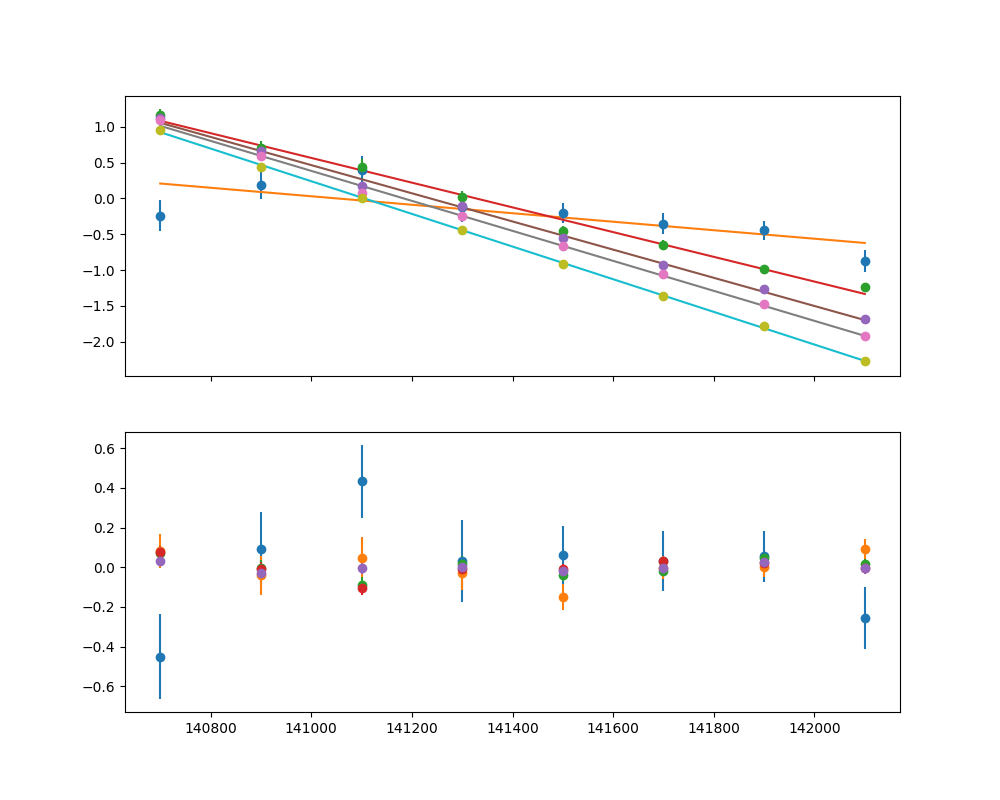

In [273]:
# Take the average phi0 across all D and E combinations. Plot all pi / 2 pulse times.
plot_label = "lf_center_freq"
x_label = "Carrier Frequency (Hz)"
take_absolute = False
col = results[:, col_indices[plot_label]]
if take_absolute:
    col = abs(col)
x = np.unique(col)
x_masks = []
for x_value in x:
    x_masks.append(col == x_value)
#x = x + 3
#x = x[1:-1]

print(x)
x_axis = np.linspace(np.min(x), np.max(x), 1000)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
xaxis = np.linspace(min(x), np.max(x), 1000)
ds = []
ers = []

for d in duration_masks:
    vals = []
    uncs = []
    for kk in range(len(x)):
        phi0_plus = results[b_mask&d&x_masks[kk], col_indices["phi0+"]]
        phi0_neg = results[b_mask&d&x_masks[kk], col_indices["phi0-"]]

        phi0_plus_nom = np.average(unumpy.nominal_values(phi0_plus))
        phi0_plus_std = unumpy.std_devs(phi0_plus)
        phi0_plus_unc = np.average(phi0_plus_std) / np.sqrt(len(phi0_plus_std))

        phi0_neg_nom = np.average(unumpy.nominal_values(phi0_neg))
        phi0_neg_std = unumpy.std_devs(phi0_neg)
        phi0_neg_unc = np.average(phi0_neg_std) / np.sqrt(len(phi0_neg_std))
        
        phi0_total = np.average([phi0_plus_nom, phi0_neg_nom])
        phi0_total_unc = np.sqrt(phi0_plus_unc**2 + phi0_neg_unc**2)
        
        vals.append(phi0_total)
        uncs.append(phi0_total_unc)

    ds.append(vals)
    ers.append(uncs)

for i in range(len(durations)):
    #color = next(ax._get_lines.prop_cycler)['color']
    fitter = get_linear_fitter(x, ds[i])
    axs[0].errorbar(x, ds[i], ers[i],fmt="o", ls="", label=f"$\\pi/2$ time = {durations[i] *1e3} $\\mu$s")
    axs[0].plot(x_axis, fitter.fitted_value(x_axis))
    axs[1].errorbar(x, fitter.residuals(), ers[i], fmt="o", ls="", label = f"$\\pi/2$ time = {durations[i] *1e3} $\\mu$s")

axs[1].set_xlabel(x_label)
axs[0].set_ylabel("Atomic Phase Offset $\\phi_0$ (rad)")
axs[1].set_ylabel("Residual (rad)")
axs[0].grid()
axs[1].grid()
axs[0].legend()
axs[1].legend()
axs[0].text(0,1.02, f"#{first} - #{last}", transform = axs[0].transAxes)
plt.tight_layout()
plt.show()

## Other

In [ ]:
# 0.01 -- 2180870 - #2189446
Time: 1688.3833258152008 s
6.849 Hz sqrt(hr)
f_b,+ = 141180(20) Hz
f_b,- = 141160(20) Hz
W_T = 8(10) Hz
Δf(b; D=±1 ,E=+1) = 15(14) Hz
Δf(b; D=±1 ,E=-1) = 1(14) Hz


# 0.05 #2192662 - #2200374
Time: 1886.7274961471558 s
6.067 Hz sqrt(hr)
f_b,+ = 141152(19) Hz
f_b,- = 141132(18) Hz
W_T = 6.6(8.4) Hz
Δf(b; D=±1 ,E=+1) = 6(12) Hz
Δf(b; D=±1 ,E=-1) = 7(12) Hz


# 0.1 -- 2175006 - #2180862
Time: 2398.7740030288696 s
3.577 Hz sqrt(hr)
f_b,+ = 141149(10) Hz
f_b,- = 141143(10) Hz
W_T = 1.9(4.4) Hz
Δf(b; D=±1 ,E=+1) = 6(6) Hz
Δf(b; D=±1 ,E=-1) = -2(6) Hz

# 0.5 #2190591 - #2192660
Time: 1438.6334819793701 s
0.237 Hz sqrt(hr)
f_b,+ = 141148(3) Hz
f_b,- = 141150(3) Hz
W_T = -0.69(37) Hz
Δf(b; D=±1 ,E=+1) = -6.09(16) Hz
Δf(b; D=±1 ,E=-1) = 4.71(17) Hz


# 1 -- 2172423 - #2175014
Time: 3096.7762269973755 s
0.388 Hz sqrt(hr)
f_b,+ = 141149.5(1.8) Hz
f_b,- = 141151.8(1.9) Hz
W_T = -0.77(42) Hz
Δf(b; D=±1 ,E=+1) = -7.79(9) Hz
Δf(b; D=±1 ,E=-1) = 6.25(8) Hz

# 5 -- #2189453 - #2190586
Time: 6330.099611997604 s
7.036 Hz sqrt(hr)
f_b,+ = 141211(12) Hz
f_b,- = 141193(12) Hz
W_T = 6.1(5.3) Hz
Δf(b; D=±1 ,E=+1) = -6(7) Hz
Δf(b; D=±1 ,E=-1) = 18(8) Hz

# 10 #2172224 - #2172412
Time: 1848.3763139247894 s
1.536 Hz sqrt(hr)
f_b,+ = 141190(20) Hz
f_b,- = 141190(20) Hz
W_T = -0.8(2.1) Hz
Δf(b; D=±1 ,E=+1) = -8(2) Hz
Δf(b; D=±1 ,E=-1) = 5(2) Hz

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_586626/2522242377.py:14: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_ylabel("$\delta W_T$ per cycle")
/tmp/ipykernel_586626/2522242377.py:15: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_ylabel("$\delta W_T \sqrt{\mathrm{hour}}$")


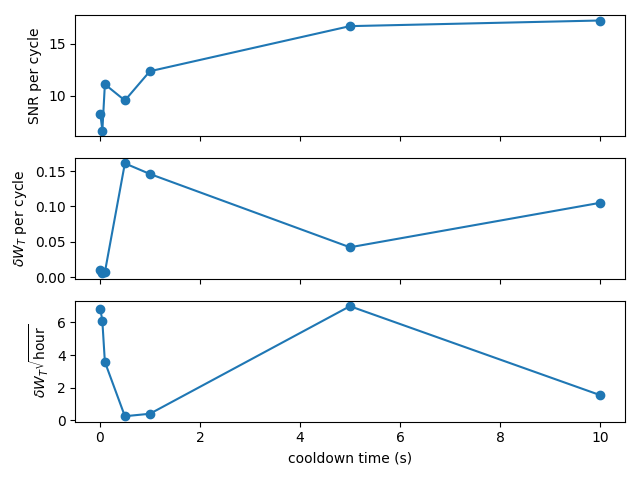

In [1249]:
times = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
cycleSNR = [8.24, 6.67, 11.1, 9.55, 12.35, 16.67, 17.21]
dWT = [10, 4.4, 4.4, 37, 42, 5.3, 2.1,]
dWTsqrthour = [6.85, 6.067, 3.577, 0.237, 0.388, 7, 1.536]
Ncycle = [953, 857, 650, 230, 288, 126, 20]

WTcyc = np.array(dWT)/np.array(Ncycle)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(times, cycleSNR, marker='o')
ax[1].plot(times, WTcyc,  marker='o')
ax[2].plot(times, dWTsqrthour,  marker='o')
ax[0].set_ylabel("SNR per cycle")
ax[1].set_ylabel("$\delta W_T$ per cycle")
ax[2].set_ylabel("$\delta W_T \sqrt{\mathrm{hour}}$")
ax[2].set_xlabel("cooldown time (s)")
# ax[1].set_ylabel(r"$$\delta W_T$$ per cycle")
plt.tight_layout()
plt.show()